<a href="https://colab.research.google.com/github/StanislaVolchkov/More-Realistic-Models/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
from tqdm import tqdm_notebook
import gc
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io 
import skimage
from skimage.transform import resize
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=60,dy=60,
                      dimx=128,dimy=128
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #print(df.shape)
    #image preprocessing
    all_photos = df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data_torch, attrs = fetch_dataset()

In [ ]:
data_torch = np.rollaxis(data_torch, 3, 1)
data_torch = torch.FloatTensor(data_torch)
data_torch.shape, data_torch.type

(torch.Size([13143, 3, 128, 128]), <function Tensor.type>)


Разбиваем выборку картинок на train и val, далее давайте продемонстрируем несколько картино, чтобы посмотреть, как они выглядят. После этого приведем картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
'''
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data_torch[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(data_torch[i+7])
plt.show();
'''

'\nplt.figure(figsize=(18, 6))\nfor i in range(6):\n    plt.subplot(2, 6, i+1)\n    plt.axis("off")\n    plt.imshow(data_torch[i])\n\n    plt.subplot(2, 6, i+7)\n    plt.axis("off")\n    plt.imshow(data_torch[i+7])\nplt.show();\n'

In [ ]:
from sklearn.model_selection import train_test_split
data_tr, data_ts = train_test_split(data_torch, train_size=0.85, shuffle=True)

batch = 128
train_loader = data_utils.DataLoader(data_tr, batch_size=batch, shuffle = True, num_workers=4, drop_last=True)
val_loader = data_utils.DataLoader(data_ts, batch_size=batch, shuffle = False, num_workers=4, drop_last=True)

In [ ]:
#len(data_tr)/64, len(data_ts)/64

In [ ]:
'''
X = next(iter(train_loader))
Y = next(iter(val_loader))
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(X[i].numpy(), 0, 3))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(Y[i].numpy(), 0, 3))
plt.show();
'''

'\nX = next(iter(train_loader))\nY = next(iter(val_loader))\nplt.figure(figsize=(18, 6))\nfor i in range(6):\n    plt.subplot(2, 6, i+1)\n    plt.axis("off")\n    plt.imshow(np.rollaxis(X[i].numpy(), 0, 3))\n\n    plt.subplot(2, 6, i+7)\n    plt.axis("off")\n    plt.imshow(np.rollaxis(Y[i].numpy(), 0, 3))\nplt.show();\n'

##Сохранение весов

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive/')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n"

In [ ]:
#Сохранение и загрузка весов модели при заданной архитектуре
def save_model(model, name, i):
  torch.save(model.state_dict(), f"/content/gdrive/MyDrive/{name}_{i}_weights.pth") 

def load_model(model, name, i):
  state_dict = torch.load(f"/content/gdrive/MyDrive/{name}_{i}_weights.pth")
  model.load_state_dict(state_dict)
  return model

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


In [ ]:
dim_code = 256 # выберем размер латентного вектора, далее в самой архитектуре это число умножается на 3

Реализуем autoencoder. Выберем Convolution Autoencoder

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(           
            nn.Conv2d(3, 64, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.Conv2d(64, 64, 3, stride = 2, padding = 1),         #nn.MaxPool2d(4,4), 
            nn.Conv2d(64, 128, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
            nn.Conv2d(128, 128, 3, stride = 2, padding = 1),          #nn.MaxPool2d(4,4), 
            nn.Flatten(),
            nn.Linear(32 * 32 * 128, 3 * dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear( 3 * dim_code, 32 * 32 * 128),
            nn.Unflatten(dim=1, unflattened_size=(128, 32, 32)),
            nn.LeakyReLU(True),
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.Conv2d(128, 64, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.Conv2d(64, 3, 3, stride = 1, padding = 1),
            nn.BatchNorm2d(3),
            nn.Hardsigmoid(True)
        )
            
    
    def forward(self, x):

      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)

      return reconstruction, latent_code

    def sample(self, z):
        generated = self.decoder(z)
        generated = generated.permute(0, 2, 3, 1)
        return generated

    def get_latent(self, z):
      latent = self.encoder(z)
      return latent

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
#model.cpu()
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Fri Dec 17 20:29:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
criterion = nn.MSELoss()

model = Autoencoder().to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, amsgrad = True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. 

In [ ]:
#!pip install torchinfo

In [ ]:
#from torchinfo import summary
#summary(model)

In [ ]:
n_epochs = 50

train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstruction, latent_code = model(X_batch.to(device))
        loss = criterion(reconstruction, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    scheduler.step()

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstruction, latent_code = model(X_batch.to(device))
          loss = criterion(reconstruction, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# 30 эпох
#train_losses[-1], val_losses[-1]

После всео цикла обучения посмотрим на конечные значения метрик и построим графики обучения.


In [ ]:
train_losses[-1], val_losses[-1]

(0.0010478826401616051, 0.0011113215160245696)

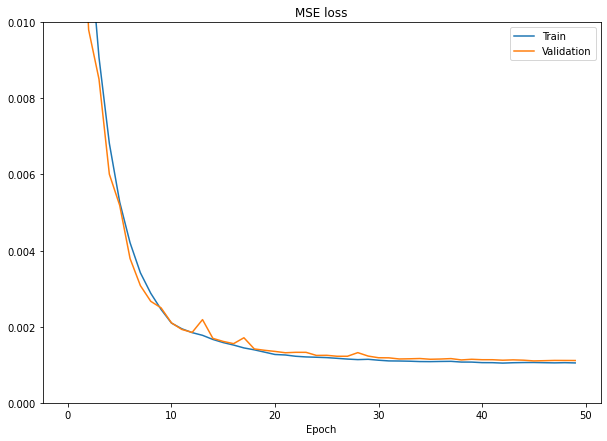

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.01)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

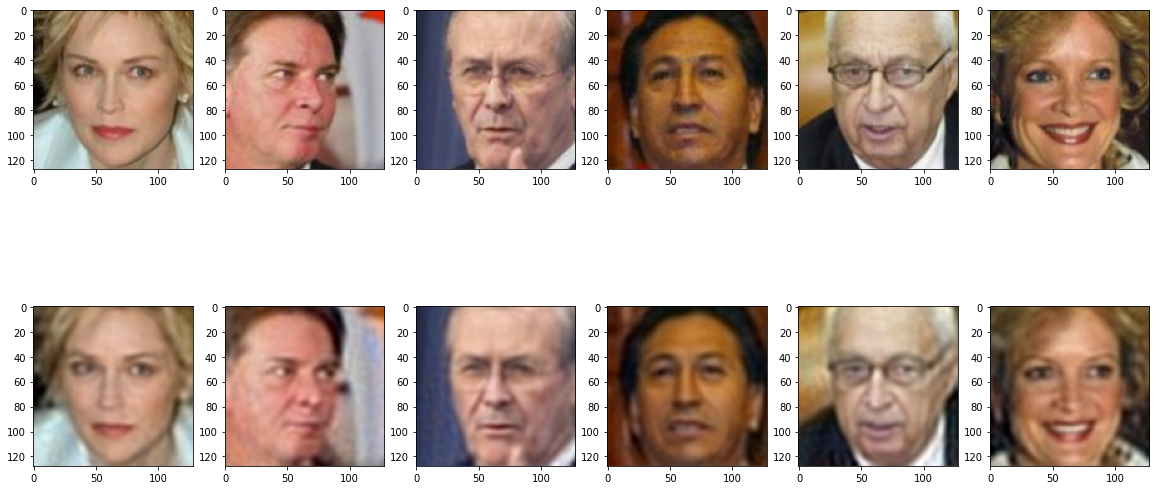

In [ ]:
for Y in val_loader:
  pass
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(Y[i+10].numpy(), 0, 3))

    plt.subplot(2, 6, i+7)
    plt.axis("on")
    plt.imshow(np.rollaxis(reconstruction[i+10].cpu().numpy(), 0, 3))
 
plt.show();

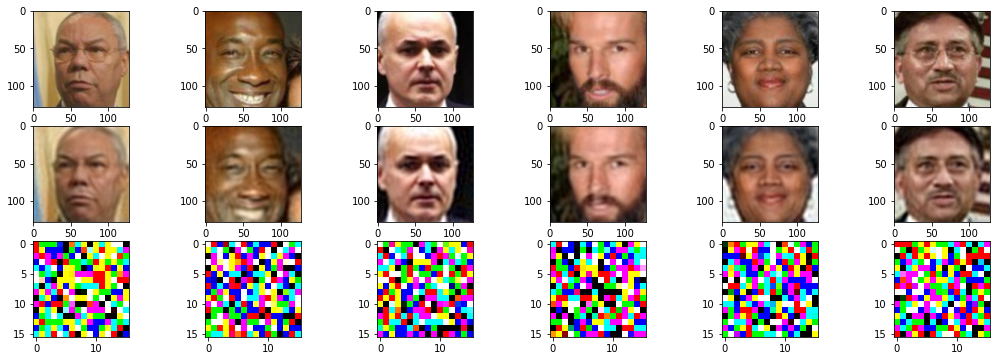

In [ ]:
for Y in val_loader:
  pass
latents = torch.sigmoid(latent_code)
latents = latents.view(-1, 16, 16, 3)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(Y[i].numpy(), 0, 3))

    plt.subplot(3, 6, i+7)
    plt.axis("on")
    plt.imshow(np.rollaxis(reconstruction[i].cpu().numpy(), 0, 3))

    plt.subplot(3, 6, i+13)
    plt.axis("on")
    plt.imshow(latents[i].cpu().numpy())   
plt.show();

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Примечание: Т.к. при сохранении стандартного нормального распределения вместо лиц у вас выводится непонятно что. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Поэтому будем генерировать вектора из распределения полученного по самому датасету. Также была применена хитрость подправления распределения с помощью умножения mean/std на некую константу, подобранную эмпирически

In [ ]:
latent_vector = torch.Tensor()
model.eval()
with torch.no_grad():
  for X_batch in train_loader:
    _, latent_code = model(X_batch.to(device))
    latent_vector = torch.cat((latent_vector, latent_code.cpu()))
  for X_batch in val_loader:
    _, latent_code = model(X_batch.to(device))
    latent_vector = torch.cat((latent_vector, latent_code.cpu()))
mean = latent_vector.mean(dim=0)
std = latent_vector.std(dim=0)

In [ ]:
latent_code.size(), latent_vector.size()

(torch.Size([128, 768]), torch.Size([13056, 768]))

In [ ]:
mean.shape , std.shape

(torch.Size([768]), torch.Size([768]))

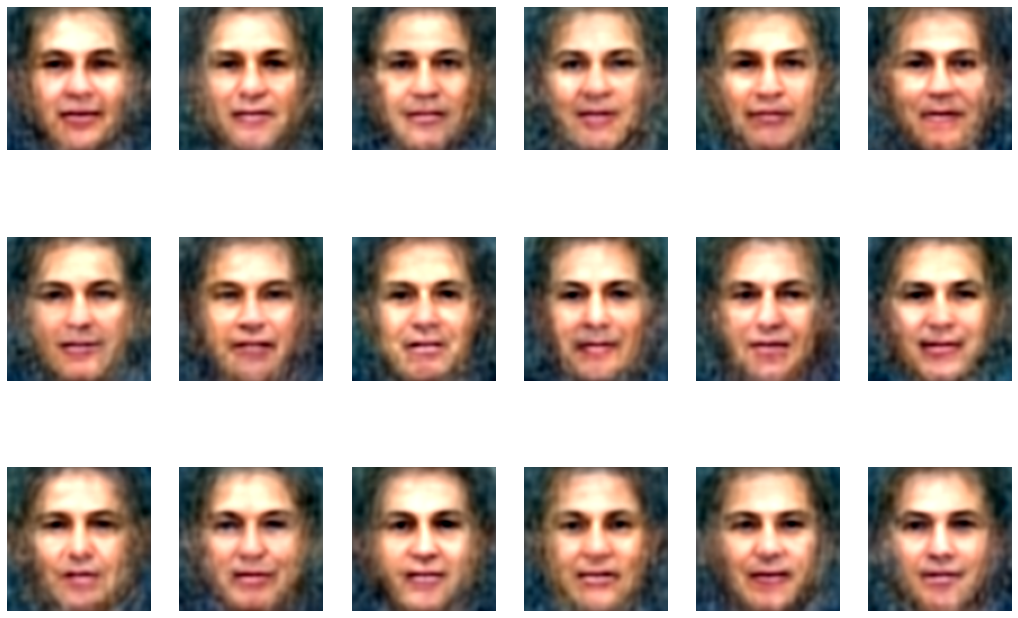

In [ ]:
z = 0.4 * std * torch.FloatTensor(np.random.randn(25, 3 * dim_code)) + 3 * mean
z = model.sample(z.to(device))
z = z.detach().cpu()

plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(z[i].numpy())

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(z[i+7].numpy())
    

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(z[i+13].numpy()) 
      
plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найдем людей с улыбками вам засчет файла с описанием датасета, скачанного вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты.

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустных

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустного!

In [ ]:
smiling = data_torch[[1984, 171, 308, 1433, 2593, 2816,\
                      3722, 3843, 4623, 4810, 5046, 5071,\
                      5448, 5497, 5619, 6220, 6468, 6842]]
                      
unsmiling = data_torch[[1983, 170, 307, 1432, 2594, 2815,\
                        3721, 3844, 4622, 4809, 5047, 5072,\
                        5447, 5496, 5620, 6221, 6467, 6843]]

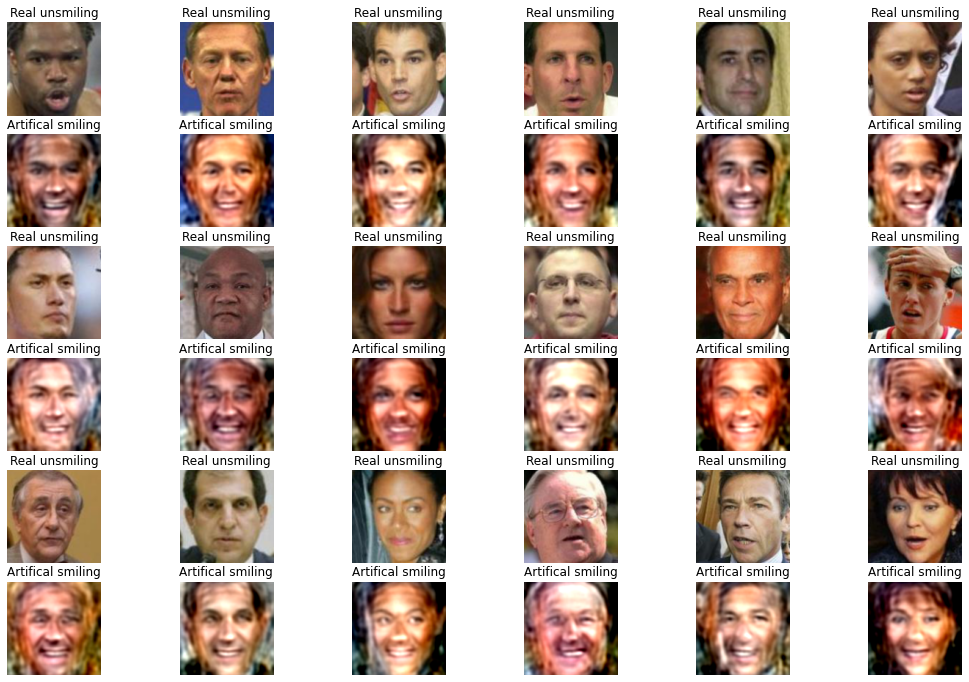

In [ ]:
latent_with_smile = model.get_latent(smiling.to(device))
latent_without_smile = model.get_latent(unsmiling.to(device))
smile_vector = latent_with_smile.mean(dim=0) - latent_without_smile.mean(dim=0)

new_smile = latent_without_smile + 3.2 * smile_vector + mean.cuda()
z = model.sample(new_smile)
z = z.detach().cpu()

plt.figure(figsize=(18, 12))
for i in range(6):

    plt.subplot(6, 6, i+1)
    plt.axis("off")
    plt.title('Real unsmiling')
    plt.imshow(np.rollaxis(unsmiling[i].numpy(), 0, 3))
    
    plt.subplot(6, 6, i+7)
    plt.axis("off")
    plt.title('Artifical smiling')
    plt.imshow(z[i].numpy())

    plt.subplot(6, 6, i+13)
    plt.axis("off")
    plt.title('Real unsmiling')
    plt.imshow(np.rollaxis(unsmiling[i+6].numpy(), 0, 3))

    plt.subplot(6, 6, i+19)
    plt.axis("off")
    plt.title('Artifical smiling')
    plt.imshow(z[i+6].numpy())

    plt.subplot(6, 6, i+25)
    plt.axis("off")
    plt.title('Real unsmiling')
    plt.imshow(np.rollaxis(unsmiling[i+12].numpy(), 0, 3))

    plt.subplot(6, 6, i+31)
    plt.axis("off")
    plt.title('Artifical smiling')
    plt.imshow(z[i+12].numpy())
     
      
plt.show();

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 500
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. В этом варианте попробуем Linear Autoencoder.

In [ ]:
features = 32

In [ ]:
class VAE(nn.Module):
    def __init__(self):

      super().__init__()

      self.flatten = nn.Flatten()

      self.encoder = nn.Sequential(
          nn.Linear(28 * 28, 14 * 14),
          #nn.BatchNorm1d(14 * 14),
          nn.ReLU(True),
          nn.Linear(14 * 14, 100),
          #nn.BatchNorm1d(100),
          nn.ReLU(True),
          nn.Linear(100, 2 * features),
      )

      self.decoder = nn.Sequential(
          nn.Linear(features, 100),
          #nn.BatchNorm1d(100),
          nn.ReLU(True),
          nn.Linear(100, 14 * 14),
          #nn.BatchNorm1d(14 * 14),
          nn.ReLU(True),
          nn.Linear(14 * 14, 28 * 28),
          #nn.BatchNorm1d(28 * 28),
          #nn.Hardsigmoid(True)
      )

    def encode(self, x):

      x = self.flatten(x).float()
      x = self.encoder(x)
      mu, logsigma = torch.split(x, features, dim=1)[0], torch.split(x, features, dim=1)[1]
      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):

        if self.training:
          std = torch.exp(0.5 * logsigma)     # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          eps = torch.randn_like(std)          # на инференсе выход автоэнкодера должен быть детерминирован.
          sample = mu + (eps * std)
        else:
          return mu
        return sample
    
    def decode(self, z):

      z = self.decoder(z)
      z = torch.sigmoid(z)
      reconstruction = z.view(-1, 1, 28, 28)
      return reconstruction

    def forward(self, x):

      mu, logsigma = self.encode(x)
      z = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(z)
      return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - logsigma.exp())
    #loss = torch.mean(-0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp(), dim = 1), dim = 0)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
model_vae.cpu()
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

In [ ]:
criterion = loss_vae

model_vae = VAE().to(device)

optimizer = optim.Adam(model_vae.parameters(), amsgrad = True)

In [ ]:
n_epochs = 150

train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model_vae.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        mu, logsigma, reconstruction = model_vae(X_batch[0].to(device))
        loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    #scheduler.step()

    model_vae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in test_loader:
          mu, logsigma, reconstruction = model_vae(X_batch[0].to(device))
          loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/150 [00:00<?, ?it/s]

Построим графики обучения для выявления переобучения и оценки общего качества обучения

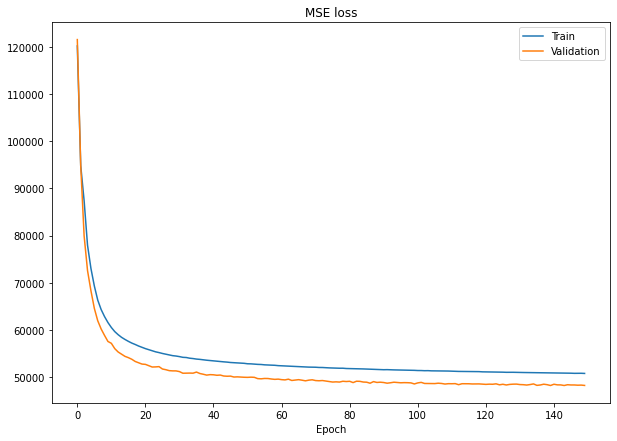

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

#plt.ylim(0, 0.5)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

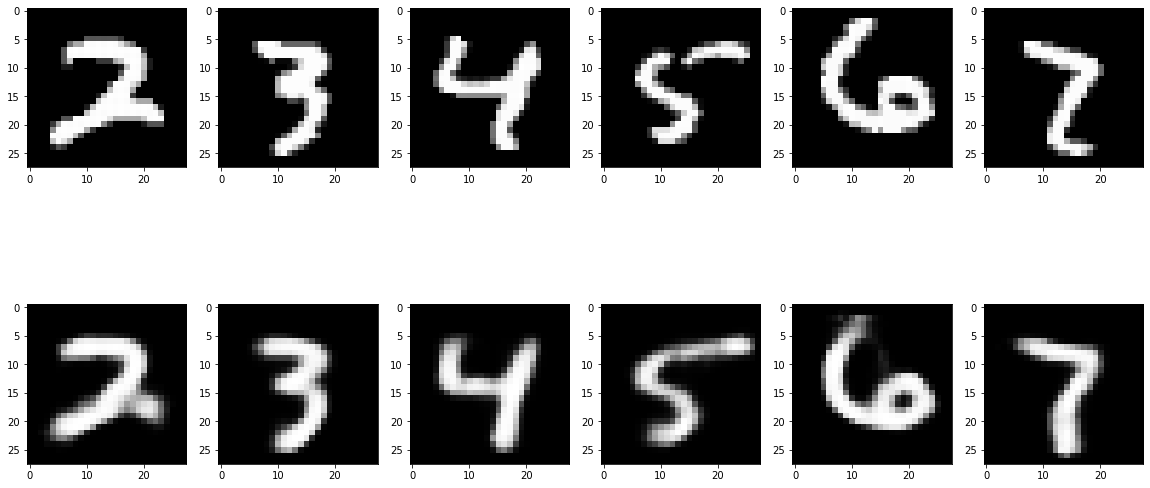

In [ ]:
for Y in test_loader:
  pass
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(Y[0][i].numpy(), 0, 3).squeeze(), cmap="gray")

    plt.subplot(2, 6, i+7)
    plt.axis("on")
    plt.imshow(np.rollaxis(reconstruction[i].cpu().numpy(), 0, 3).squeeze(), cmap="gray")
 
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

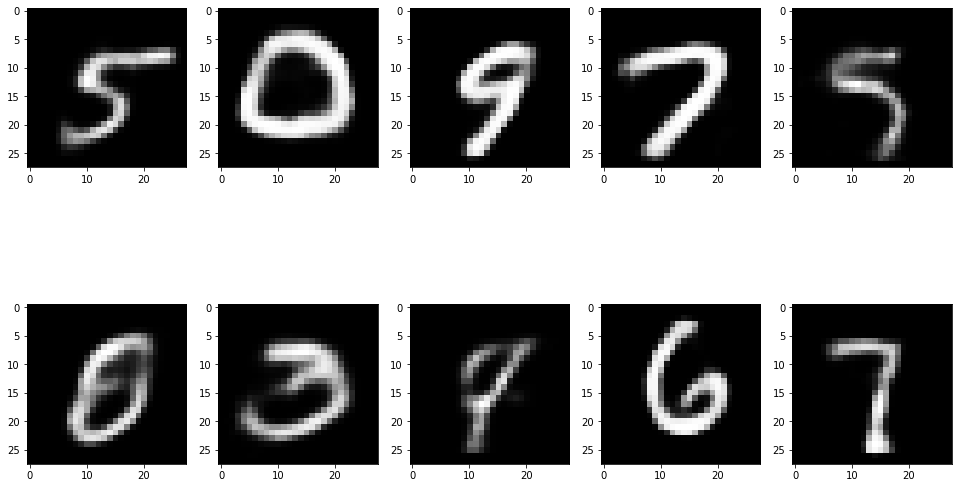

In [ ]:
z = torch.Tensor([np.random.normal(0, 1, features) for i in range(12)])
output = model_vae.decode(z.to(device))
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(2, 6, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(output[i].detach().cpu().numpy(), 0, 3).squeeze(), cmap="gray")

    plt.subplot(2, 6, i+7)
    plt.axis("on")
    plt.imshow(np.rollaxis(output[i+7].detach().cpu().numpy(), 0, 3).squeeze(), cmap="gray")
 
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном пространстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощью `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


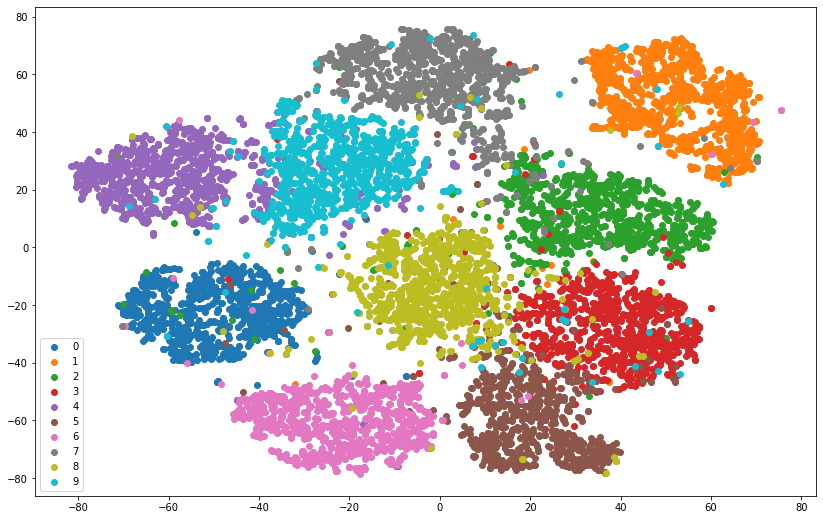

In [ ]:
test_latent, test_label = torch.Tensor([]), torch.Tensor([])
model_vae.eval()
with torch.no_grad():
  for X_batch in test_loader:
    mu, _ = model_vae.encode(X_batch[0].to(device))
    test_latent = torch.cat((test_latent, mu.cpu()))
    test_label = torch.cat((test_label, X_batch[1]))

t_sne = TSNE()
latent_visual = t_sne.fit_transform(test_latent)

plt.figure(figsize=(14, 9))
for i in range(10):
  plt.scatter(latent_visual[test_label == i, 0], latent_visual[test_label == i, 1], label = str(i))
  plt.legend()
plt.show()

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы создадим подобную сеть.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
   def __init__(self):

      super().__init__()

      self.flatten = nn.Flatten()

      self.encoder = nn.Sequential(
          nn.Linear(28 * 28 + 10, 14 * 14),
          nn.ReLU(True),
          nn.Linear(14 * 14, 100),
          nn.ReLU(True),
          nn.Linear(100, 2 * features),
      )

      self.decoder = nn.Sequential(
          nn.Linear(features + 10, 100),
          nn.ReLU(True),
          nn.Linear(100, 14 * 14),
          nn.ReLU(True),
          nn.Linear(14 * 14, 28 * 28),
      )

   def encode(self, x, class_num):
     
     x = self.flatten(x).float()
     x = torch.cat((x, class_num), dim = 1)
     x = self.encoder(x)
     mu, logsigma = torch.split(x, features, dim=1)[0], torch.split(x, features, dim=1)[1]
        
     return mu, logsigma #, class_num
    
   def gaussian_sampler(self, mu, logsigma):
     
     if self.training:
       std = torch.exp(0.5 * logsigma)     # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
       eps = torch.randn_like(std)          # на инференсе выход автоэнкодера должен быть детерминирован.
       sample = mu + (eps * std)
     else:
       return mu
     return sample
    
   def decode(self, z, class_num):
     
     z = torch.cat((z, class_num), dim = 1)
     z = self.decoder(z)
     z = torch.sigmoid(z)
     reconstruction = z.view(-1, 1, 28, 28)
     return reconstruction

   def forward(self, x, class_num):

     mu, logsigma = self.encode(x, class_num)
     z = self.gaussian_sampler(mu, logsigma)
     reconstruction = self.decode(z, class_num)
     return mu, logsigma, reconstruction

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - logsigma.exp())
    #loss = torch.mean(-0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp(), dim = 1), dim = 0)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_cvae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
model_cvae.cpu()
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

In [ ]:
criterion = loss_cvae

model_cvae = CVAE().to(device)

optimizer = optim.Adam(model_cvae.parameters(), amsgrad = True)

n_epochs = 150

train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model_cvae.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        class_num = F.one_hot(X_batch[1], num_classes=10)
        mu, logsigma, reconstruction = model_cvae(X_batch[0].to(device), class_num.to(device))
        loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))


    model_cvae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in test_loader:

          class_num = F.one_hot(X_batch[1], num_classes=10)
          mu, logsigma, reconstruction = model_cvae(X_batch[0].to(device), class_num.to(device))
          loss = criterion(X_batch[0].to(device), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/150 [00:00<?, ?it/s]

Построим графики обучения для выявления переобучения и оценки общего качества обучения

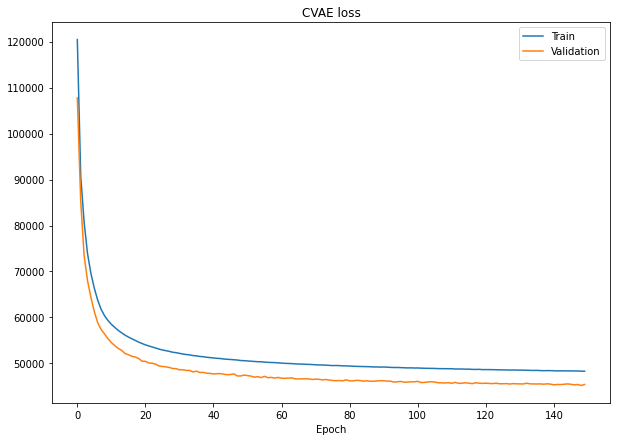

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

#plt.ylim(0, 12000)
plt.xlabel('Epoch')
plt.title('CVAE loss')
plt.legend()
plt.show()

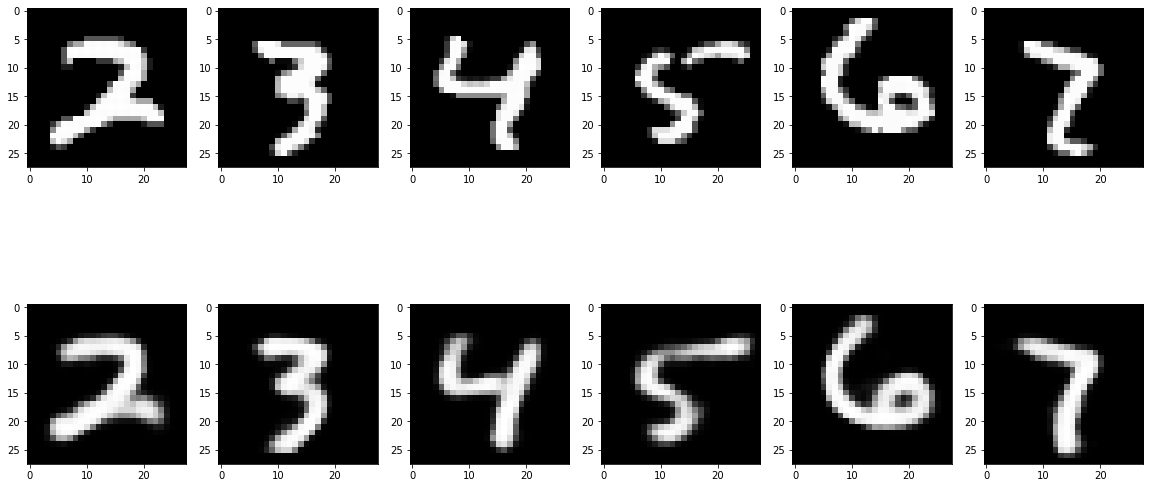

In [ ]:
for Y in test_loader:
  pass
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(Y[0][i].numpy(), 0, 3).squeeze(), cmap="gray")

    plt.subplot(2, 6, i+7)
    plt.axis("on")
    plt.imshow(np.rollaxis(reconstruction[i].cpu().numpy(), 0, 3).squeeze(), cmap="gray")
 
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

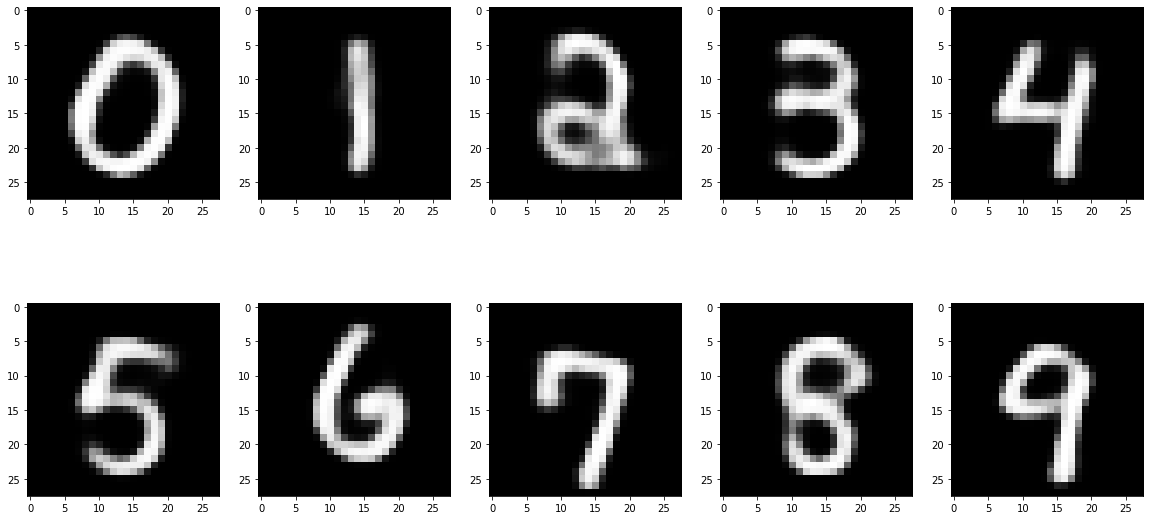

In [ ]:
z = torch.Tensor(np.random.normal(0, 1, features))
plt.figure(figsize=(20, 10))
for i in range(10):
    number = F.one_hot(torch.Tensor([i]).long(), num_classes = 10)
    output = model_cvae.decode(z.unsqueeze(0).to(device), number.to(device))
    plt.subplot(2, 5, i+1)
    plt.axis("on")
    plt.imshow(np.rollaxis(output.detach().cpu().numpy(), 0, 3).squeeze(), cmap="gray")
 
plt.show()

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


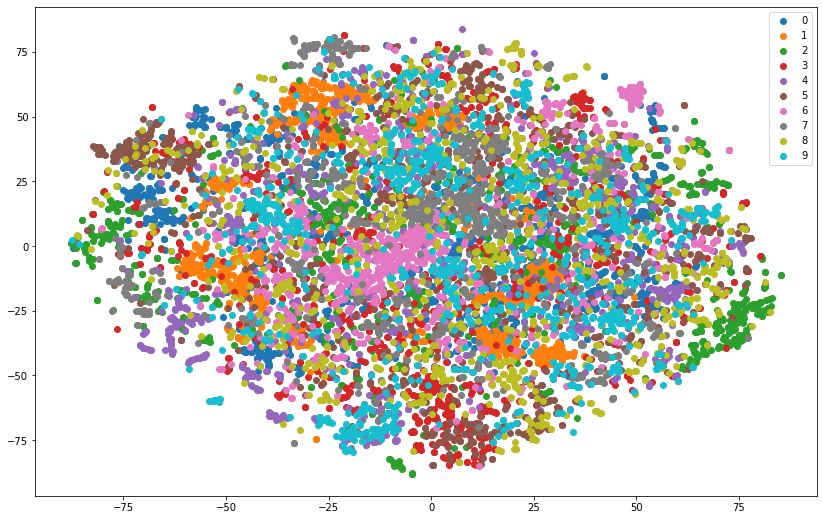

In [ ]:
test_latent, test_label = torch.Tensor([]), torch.Tensor([])
model_cvae.eval()
with torch.no_grad():
  for X_batch in test_loader:
    class_num = F.one_hot(X_batch[1], num_classes=10)
    mu, _ = model_cvae.encode(X_batch[0].to(device), class_num.to(device))
    test_latent = torch.cat((test_latent, mu.cpu()))
    test_label = torch.cat((test_label, X_batch[1]))


t_sne = TSNE()
latent_visual = t_sne.fit_transform(test_latent)

plt.figure(figsize=(14, 9))
for i in range(10):
  plt.scatter(latent_visual[test_label == i, 0], latent_visual[test_label == i, 1], label = str(i))
  plt.legend()
plt.show()

В следующей ячейке я попробовал отнормировать латентные представления наших изображений для более четко разделенной по классам визуализации. Но это оказалось лишним, так как плохо разделенные кластеры для CVAE - это нормальная ситуация

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


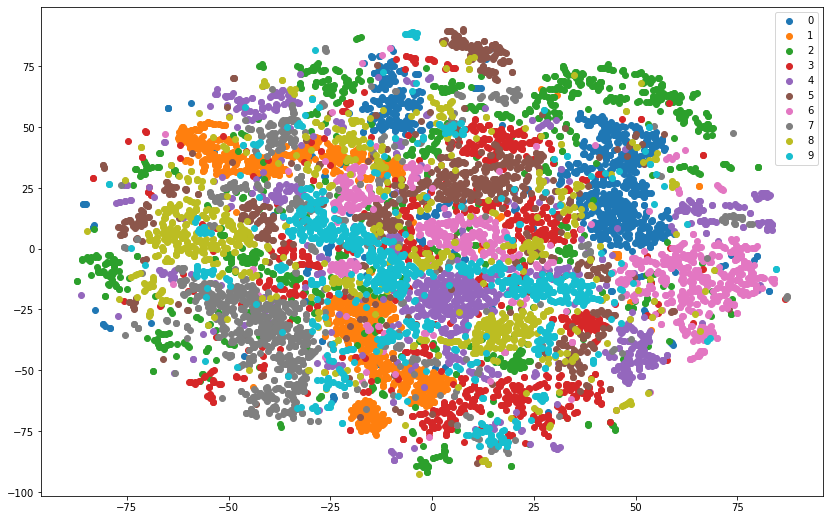

In [ ]:
test_latent, test_label = torch.Tensor([]), torch.Tensor([])
model_cvae.eval()
with torch.no_grad():
  for X_batch in test_loader:
    class_num = F.one_hot(X_batch[1], num_classes=10)
    mu, _ = model_cvae.encode(X_batch[0].to(device), class_num.to(device))
    test_latent = torch.cat((test_latent, mu.cpu()))
    test_label = torch.cat((test_label, X_batch[1]))

test_latent = StandardScaler().fit_transform(test_latent)
t_sne = TSNE()
latent_visual = t_sne.fit_transform(test_latent)

plt.figure(figsize=(14, 9))
for i in range(10):
  plt.scatter(latent_visual[test_label == i, 0], latent_visual[test_label == i, 1], label = str(i))
  plt.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Да, так как CVAE обучается общей стилистике изображений, в то время как обычный вариационный автоенкодер пытается четко выделять все особенности каждой картинки и кластеризовать их.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

NameError: ignored

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>